### What data I chose? 

[Heart failure and clinical records](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records)


### Data description:

This dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features.

#### Variables table: 

| Variable Name             | Role    | Type       | Demographic | Description                                              | Units             | Missing Values |
|---------------------------|---------|------------|-------------|----------------------------------------------------------|-------------------|----------------|
| age                       | Feature | Integer    | Age         | Age of the patient                                       | years             | no             |
| anaemia                   | Feature | Binary     |             | Decrease of red blood cells or hemoglobin                |                   | no             |
| creatinine_phosphokinase  | Feature | Integer    |             | Level of the CPK enzyme in the blood                     | mcg/L             | no             |
| diabetes                  | Feature | Binary     |             | Whether the patient has diabetes                         |                   | no             |
| ejection_fraction         | Feature | Integer    |             | Percentage of blood leaving the heart at each contraction| %                 | no             |
| high_blood_pressure       | Feature | Binary     |             | Whether the patient has hypertension                     |                   | no             |
| platelets                 | Feature | Continuous |             | Platelets in the blood                                   | kiloplatelets/mL  | no             |
| serum_creatinine          | Feature | Continuous |             | Level of serum creatinine in the blood                   | mg/dL             | no             |
| serum_sodium              | Feature | Integer    |             | Level of serum sodium in the blood                       | mEq/L             | no             |
| sex                       | Feature | Binary     | Sex         | Gender of the patient                                    |                   | no             |
| smoking                   | Feature | Binary     |             | Whether the patient smokes or not                        |                   | no             |
| time                      | Feature | Integer    |             | Follow-up period                                         |                   | no             |
| death_event               | Feature | Binary     |             | Whether the patient died during the follow-up period     |                   | no             |

### Dada Processing: 

the chosen data set does not require any additional cleaning, as it has no missing values.

In [5]:
import pandas as pd

data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

### Analysis of the data: 

The first step will be to create a corelation matrix to get more information about the variables in the data.

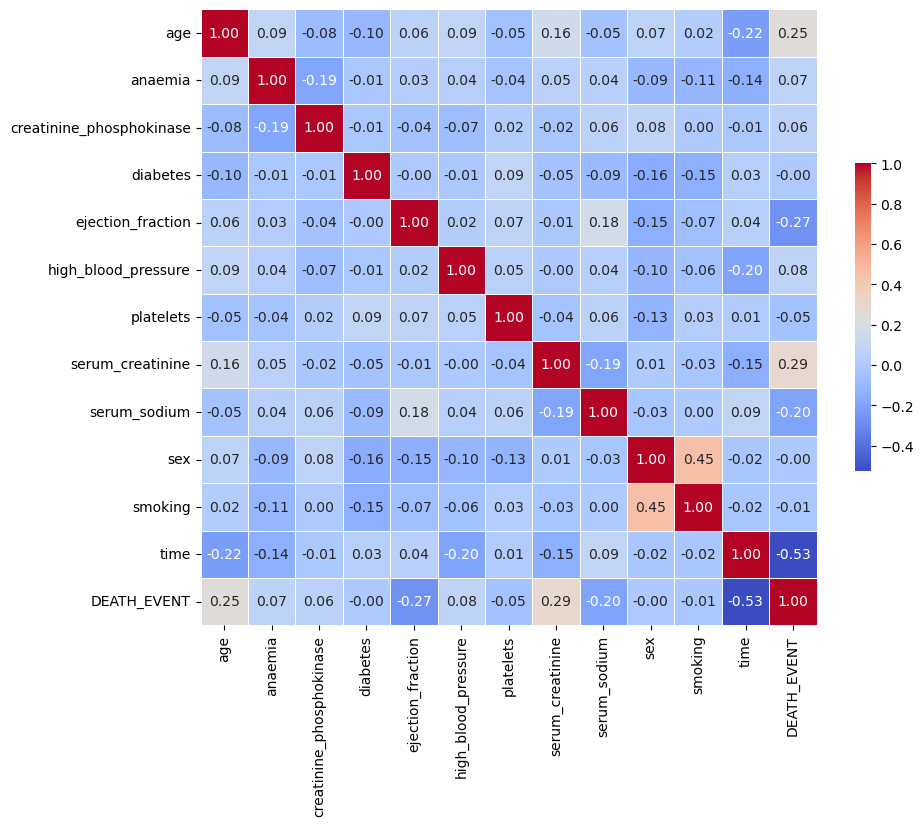

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Conclusions from the correlation matrix: 

From reading the correlation matrix we can observe suspiciously high correlation between `DEATH_EVENT` and `time` variables. This suggests that the follow-up period might be influenced directly be the death of a patient, which makes sense as such an event would trigger a communication with researchers. For this reason we exclude time from the data. 

note: Interestingly I didn't do it right away and it changed the results of the next section to `linearRegression` which is expected as this model is good at isolating the single impactful variable, but I think still worth noting. 

In [7]:
data = data.drop('time', axis=1)

### What will be trying to predict? 

For the chosen data set it seems reasonable to try and predict `DEATH_EVENT` as thats what we are usually trying to prevent.

We will try to do it using Logistic Regression, KNeighborsClassifier and SVC models. And will compare their results afterwords. 

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

param_grid = {
    'Logistic Regression': { 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs'] },
    'KNN': { 'n_neighbors': [3, 5, 7, 9, 11] },
    'SVM': { 'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'] }
}

best_accuracy = 0
best_classifier = None
best_params = None

for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], scoring='accuracy', cv=5)
    grid_search.fit(X_train_scaled, y_train)
    if grid_search.best_score_ > best_accuracy:
        best_accuracy = grid_search.best_score_
        best_classifier = name
        best_params = grid_search.best_params_

print(f"Best Classifier: {best_classifier}")
print(f"Best Parameters: {best_params}")
print(f"Best Training Accuracy: {best_accuracy}")

model = models[best_classifier]
model.set_params(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy}")
print("Classification Report:")
print(classification_rep)


Best Classifier: SVM
Best Parameters: {'C': 10, 'kernel': 'linear'}
Best Training Accuracy: 0.7740248226950355
Test Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75        35
           1       0.70      0.28      0.40        25

    accuracy                           0.65        60
   macro avg       0.67      0.60      0.58        60
weighted avg       0.67      0.65      0.61        60



### Conclusions: 

We can observe that the most effective (or to better put it accurate) model  turned out to be SVM. 